# 02 – Baseline (TF-IDF + Logistic Regression)

Ziel: Ein klassisches ML-Baseline-Modell trainieren, um später den Mehrwert von BERT (Deep Learning) zu quantifizieren.

In [1]:
import pandas as pd
from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

## 1) CSV laden

In [2]:
PROJECT_ROOT = Path.cwd().parent
CSV_PATH = PROJECT_ROOT / "data" / "processed" / "bbc_news.csv"

df = pd.read_csv(CSV_PATH, encoding="utf-8")
df.shape, df["label"].nunique()

((2225, 5), 5)

In [3]:
df.head(2)

,id,label,text,source_file,n_chars
0,1,business,Ad sales boost Time Warner profit\n\nQuarterly...,data\raw\bbc\business\001.txt,2559
1,2,business,Dollar gains on Greenspan speech\n\nThe dollar...,data\raw\bbc\business\002.txt,2252


## 2) Train/Validation/Test Split

**Strategie:** 60% Train / 20% Validation / 20% Test
- Train: Modell trainieren
- Validation: Hyperparameter-Tuning, Model Selection
- Test: Finale Evaluation (nur EINMAL am Schluss!)

In [4]:
X = df["text"]
y = df["label"]

# Erst Test-Set abspalten (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# Dann Val-Set aus dem Rest (25% von 80% = 20% vom Gesamtdataset)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    random_state=42,
    stratify=y_temp
)

print("Train:", X_train.shape, "Validation:", X_val.shape, "Test:", X_test.shape)
print(f"Split: {len(X_train)/len(X)*100:.1f}% / {len(X_val)/len(X)*100:.1f}% / {len(X_test)/len(X)*100:.1f}%")
print("\nTrain label dist:\n", y_train.value_counts(normalize=True).round(3))
print("\nValidation label dist:\n", y_val.value_counts(normalize=True).round(3))
print("\nTest label dist:\n", y_test.value_counts(normalize=True).round(3))

Train: (1335,) Validation: (445,) Test: (445,)
Split: 60.0% / 20.0% / 20.0%

Train label dist:
 label
sport            0.230
business         0.229
politics         0.187
tech             0.180
entertainment    0.174
Name: proportion, dtype: float64

Validation label dist:
 label
business         0.229
sport            0.229
politics         0.187
tech             0.182
entertainment    0.173
Name: proportion, dtype: float64

Test label dist:
 label
business         0.229
sport            0.229
politics         0.189
tech             0.180
entertainment    0.173
Name: proportion, dtype: float64


## 3) Baseline Modell: TF-IDF + Logistic Regression

In [5]:
baseline_clf = Pipeline([
    ("tfidf", TfidfVectorizer(
        lowercase=True,
        stop_words="english",
        ngram_range=(1, 2),
        max_features=50000
    )),
    ("logreg", LogisticRegression(
        max_iter=2000,
        n_jobs=-1,
        class_weight=None
    ))
])
baseline_clf

Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=50000, ngram_range=(1, 2),
                                 stop_words='english')),
                ('logreg', LogisticRegression(max_iter=2000, n_jobs=-1))])

### Hyperparameter-Tuning mit Grid Search (Optional)

Nutzt 5-Fold CV für Konsistenz mit Notebook 07_01.

In [6]:
# Parameter-Grid definieren
param_grid = {
    'tfidf__max_features': [10000, 30000, 50000],
    'tfidf__ngram_range': [(1, 1), (1, 2)],
    'logreg__C': [0.1, 1.0, 10.0]
}

# GridSearchCV mit 5-Fold CV
grid_search = GridSearchCV(
    baseline_clf,
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

print("Starte Grid Search mit 5-Fold CV...")
grid_search.fit(X_train, y_train)

print("\n✅ Grid Search abgeschlossen!")
print("Beste Parameter:", grid_search.best_params_)
print("Beste CV-Accuracy:", round(grid_search.best_score_, 4))

baseline_clf = grid_search.best_estimator_

Starte Grid Search mit 5-Fold CV...
Fitting 5 folds for each of 18 candidates, totalling 90 fits

✅ Grid Search abgeschlossen!
Beste Parameter: {'logreg__C': 1.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}
Beste CV-Accuracy: 0.9723


### Alternative: Manuelles Training (wenn Grid Search übersprungen wird)

In [7]:
# # Nur ausführen, wenn Grid Search übersprungen wird!
# baseline_clf.fit(X_train, y_train)
# print("✅ Modell trainiert")

## 4) Evaluation auf Validation Set

In [8]:
y_val_pred = baseline_clf.predict(X_val)
acc_val = accuracy_score(y_val, y_val_pred)
print("Validation Accuracy:", round(acc_val, 4))

Validation Accuracy: 0.9798


In [9]:
print(classification_report(y_val, y_val_pred))

               precision    recall  f1-score   support

     business       0.94      0.99      0.97       102
entertainment       0.96      0.97      0.97        77
     politics       1.00      0.96      0.98        83
        sport       1.00      1.00      1.00       102
         tech       1.00      0.96      0.98        81

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



## Confusion Matrix (Validation Set)

In [10]:
import numpy as np

labels_sorted = sorted(df["label"].unique())
cm = confusion_matrix(y_val, y_val_pred, labels=labels_sorted)

cm_df = pd.DataFrame(cm, index=labels_sorted, columns=labels_sorted)
cm_df

,business,entertainment,politics,sport,tech
business,101,1,0,0,0
entertainment,2,75,0,0,0
politics,3,0,80,0,0
sport,0,0,0,102,0
tech,1,2,0,0,78


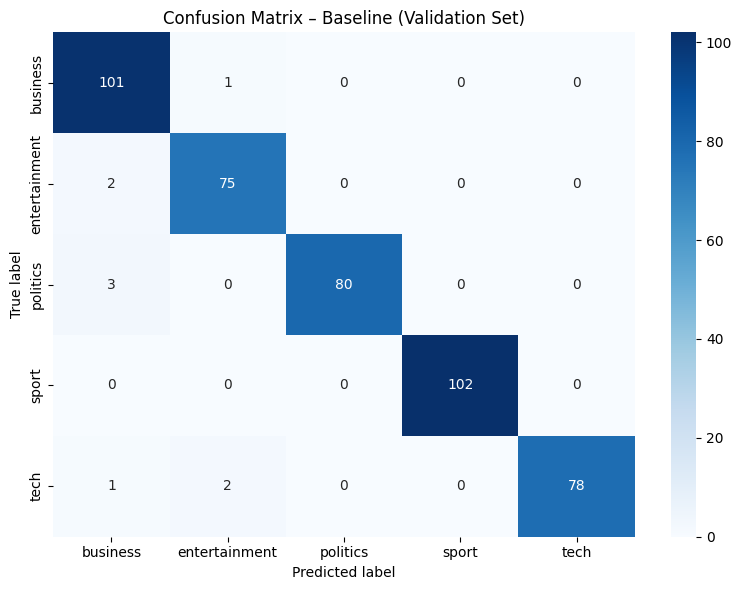

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix – Baseline (Validation Set)")
plt.tight_layout()
plt.show()

Normalisierte Confusion Matrix

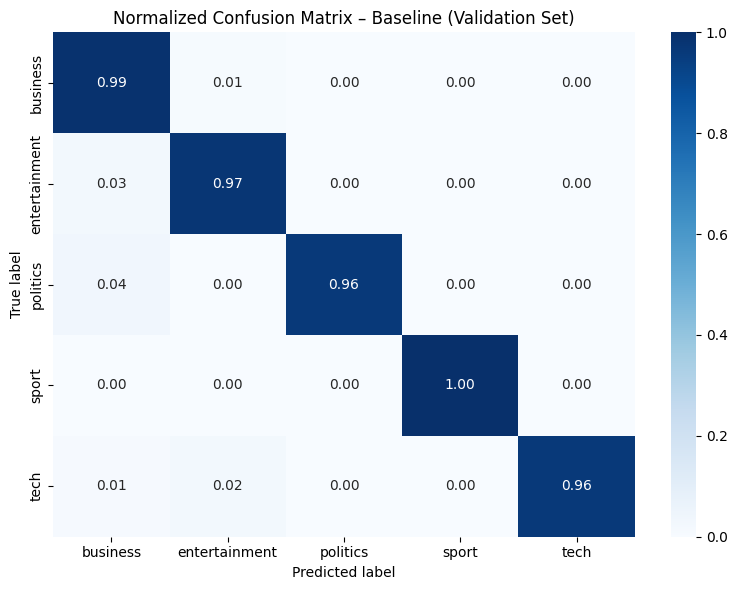

In [12]:
cm_norm = cm.astype("float") / cm.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(
    cm_norm,
    annot=True,
    fmt=".2f",
    cmap="Blues",
    xticklabels=labels_sorted,
    yticklabels=labels_sorted
)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Baseline (Validation Set)")
plt.tight_layout()
plt.show()

In [13]:
print("Diagonalwerte (= Recall pro Klasse):")
for i, label in enumerate(labels_sorted):
    print(f"{label}: {cm_norm[i, i]:.2%}")

Diagonalwerte (= Recall pro Klasse):
business: 99.02%
entertainment: 97.40%
politics: 96.39%
sport: 100.00%
tech: 96.30%


Plot speichern

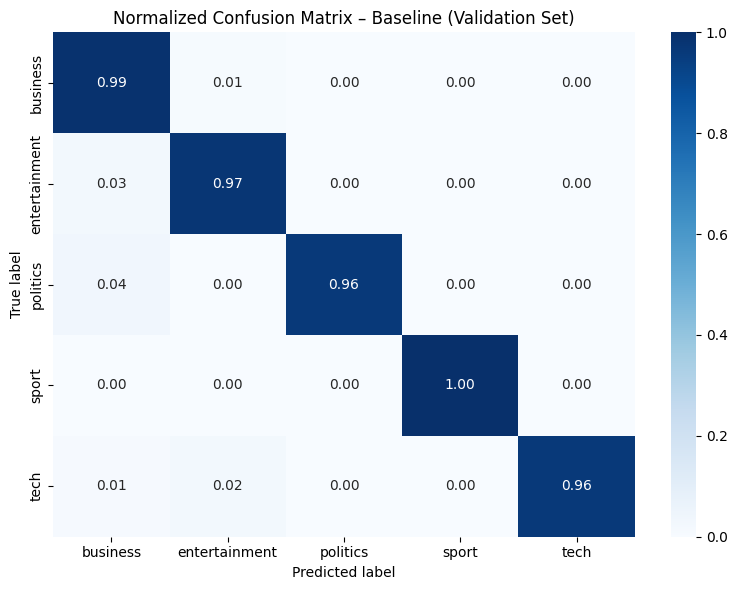

Saved to: c:\CAS\cas-ml-document-classification\results\baseline_confusion_matrix_validation.png


In [14]:
fig_path = PROJECT_ROOT / "results" / "baseline_confusion_matrix_validation.png"
fig_path.parent.mkdir(exist_ok=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Baseline (Validation Set)")
plt.tight_layout()
plt.savefig(fig_path, dpi=300)
plt.show()

print("Saved to:", fig_path)

## 5) Error Analysis

In [15]:
results = pd.DataFrame({
    "true": y_val.values,
    "pred": y_val_pred,
    "text": X_val.values
})

errors = results[results["true"] != results["pred"]].copy()
print("Fehler:", len(errors), "von", len(results))
errors.head(10)

Fehler: 9 von 445


,true,pred,text
79,politics,business,Hewitt decries 'career sexism'\n\nPlans to ext...
93,tech,entertainment,Web radio takes Spanish rap global\n\nSpin the...
132,tech,business,China 'ripe' for media explosion\n\nAsia is se...
188,politics,business,Minimum wage increased to £5.05\n\nThe minimum...
194,politics,business,Hatfield executives go on trial\n\nEngineering...
215,business,entertainment,"McDonald's to sponsor MTV show\n\nMcDonald's, ..."
280,entertainment,business,UK's National Gallery in the pink\n\nThe Natio...
300,entertainment,business,Wal-Mart is sued over rude lyrics\n\nThe paren...
342,tech,entertainment,BBC leads interactive Bafta wins\n\nThe BBC an...


Data Leakage Check

In [16]:
train_texts = set(X_train)
val_texts = set(X_val)
test_texts = set(X_test)

print("Train ∩ Val:", len(train_texts.intersection(val_texts)))
print("Train ∩ Test:", len(train_texts.intersection(test_texts)))
print("Val ∩ Test:", len(val_texts.intersection(test_texts)))
print("\n✅ Alle sollten 0 sein!")

Train ∩ Val: 23
Train ∩ Test: 23
Val ∩ Test: 10

✅ Alle sollten 0 sein!


## 6) Cross-Validation auf Train-Set

5-Fold CV nur auf Train-Set für robustere Schätzung.

**WICHTIG:** Cross-Validation sollte nur auf dem Train-Set durchgeführt werden, nicht auf dem gesamten Dataset!

Das vermeidet Data Leakage und gibt eine robustere Schätzung der Modell-Performance.

In [17]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(baseline_clf, X_train, y_train, cv=5, scoring='accuracy')
print("5-Fold CV Scores:", cv_scores.round(3))
print("Mean CV Accuracy:", cv_scores.mean().round(4), "±", cv_scores.std().round(4))

5-Fold CV Scores: [0.966 0.97  0.959 0.989 0.978]
Mean CV Accuracy: 0.9723 ± 0.0102


Top Features pro Klasse

Zeigt, ob das Modell sinnvolle Wörter lernt

In [18]:
# Prüfe, ob das Modell sinnvolle Wörter lernt (keine verdächtig einfachen Patterns)
vectorizer = baseline_clf.named_steps["tfidf"]
logreg = baseline_clf.named_steps["logreg"]

feature_names = vectorizer.get_feature_names_out()

print("Top 10 Features pro Klasse:\n")
for i, label in enumerate(sorted(df["label"].unique())):
    coefs = logreg.coef_[i]
    top_indices = coefs.argsort()[-10:][::-1]
    top_features = [feature_names[idx] for idx in top_indices]
    print(f"{label:15s}: {', '.join(top_features)}")

Top 10 Features pro Klasse:

business       : bank, shares, economy, growth, company, economic, oil, market, sales, firm
entertainment  : film, music, band, album, singer, tv, festival, star, chart, awards
politics       : mr, labour, blair, party, election, government, said, minister, secretary, mr blair
sport          : win, cup, england, injury, match, club, players, game, team, season
tech           : software, computer, users, online, technology, games, mobile, people, net, digital


## 7) Finale Evaluation auf Test-Set

**Nur EINMAL am Schluss!**

In [19]:
y_test_pred = baseline_clf.predict(X_test)
acc_test = accuracy_score(y_test, y_test_pred)

print("=" * 60)
print("FINALE TEST-SET EVALUATION")
print("=" * 60)
print(f"Test Accuracy: {acc_test:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))

FINALE TEST-SET EVALUATION
Test Accuracy: 0.9820

Classification Report:
               precision    recall  f1-score   support

     business       0.97      0.97      0.97       102
entertainment       0.99      1.00      0.99        77
     politics       0.99      0.95      0.97        84
        sport       0.99      1.00      1.00       102
         tech       0.98      0.99      0.98        80

     accuracy                           0.98       445
    macro avg       0.98      0.98      0.98       445
 weighted avg       0.98      0.98      0.98       445



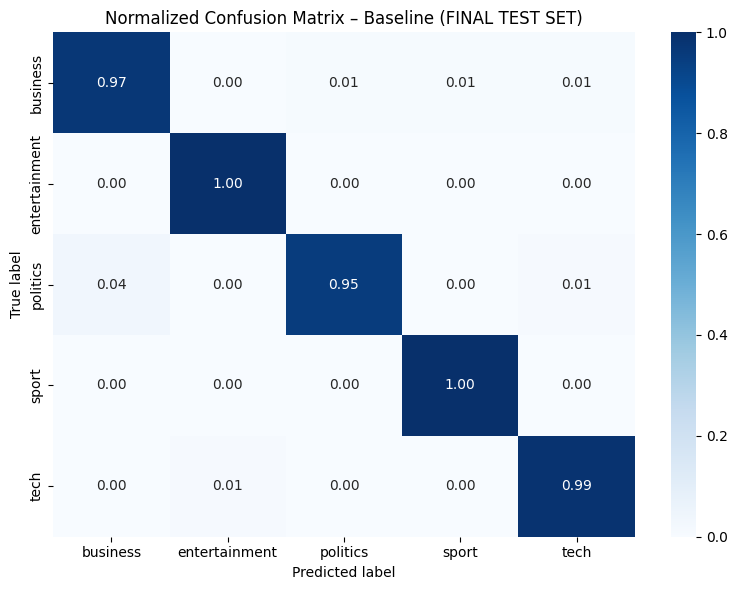


✅ Gespeichert: c:\CAS\cas-ml-document-classification\results\baseline_confusion_matrix_TEST.png


In [20]:
cm_test = confusion_matrix(y_test, y_test_pred, labels=labels_sorted)
cm_test_norm = cm_test.astype("float") / cm_test.sum(axis=1, keepdims=True)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Baseline (FINAL TEST SET)")
plt.tight_layout()
plt.show()

# Speichern
fig_path_test = PROJECT_ROOT / "results" / "baseline_confusion_matrix_TEST.png"
plt.figure(figsize=(8, 6))
sns.heatmap(cm_test_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=labels_sorted, yticklabels=labels_sorted)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Normalized Confusion Matrix – Baseline (FINAL TEST SET)")
plt.tight_layout()
plt.savefig(fig_path_test, dpi=300)
plt.close()
print(f"\n✅ Gespeichert: {fig_path_test}")

In [21]:
print(type(baseline_clf))
print(hasattr(baseline_clf, 'best_params_'))

<class 'sklearn.pipeline.Pipeline'>
False


In [22]:
print("Typ von baseline_clf:", type(baseline_clf).__name__)
print("Hat best_params_?", hasattr(baseline_clf, 'best_params_'))

# Wenn grid_search existiert:
try:
    print("\nGrid Search Ergebnis:")
    print("Beste Parameter:", grid_search.best_params_)
    print("Beste Score:", grid_search.best_score_)
    print("Grid Search wurde ausgeführt!")
except NameError:
    print("\n⚠️ Variable 'grid_search' existiert nicht!")

Typ von baseline_clf: Pipeline
Hat best_params_? False

Grid Search Ergebnis:
Beste Parameter: {'logreg__C': 1.0, 'tfidf__max_features': 30000, 'tfidf__ngram_range': (1, 2)}
Beste Score: 0.9722846441947567
Grid Search wurde ausgeführt!
